In [1]:
# imports
import os
import cv2
import PIL
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# style
sns.set_style('darkgrid')
plt.rcParams["patch.force_edgecolor"] = True
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24)

In [3]:
ls

LICENSE                       test/
Modeling.ipynb                test_ship_segmentations.csv*
README.md                     train/
Strategies                    train_ship_segmentations.csv*
sample_submission.csv*


In [4]:
train = os.listdir("train/")

In [5]:
# Playing with PIL
pill_img = PIL.Image.open("train/000c34352.jpg").resize((200,200))

In [6]:
rgb_pixels = np.array(pill_img)
print(rgb_pixels.shape)
rgb_pixels = rgb_pixels[:, :, 1]
print(rgb_pixels.shape)

(200, 200, 3)
(200, 200)


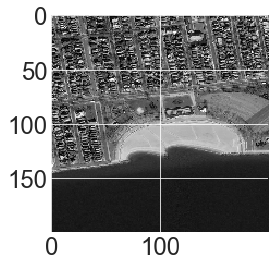

In [7]:
plt.imshow(rgb_pixels, cmap="gray")

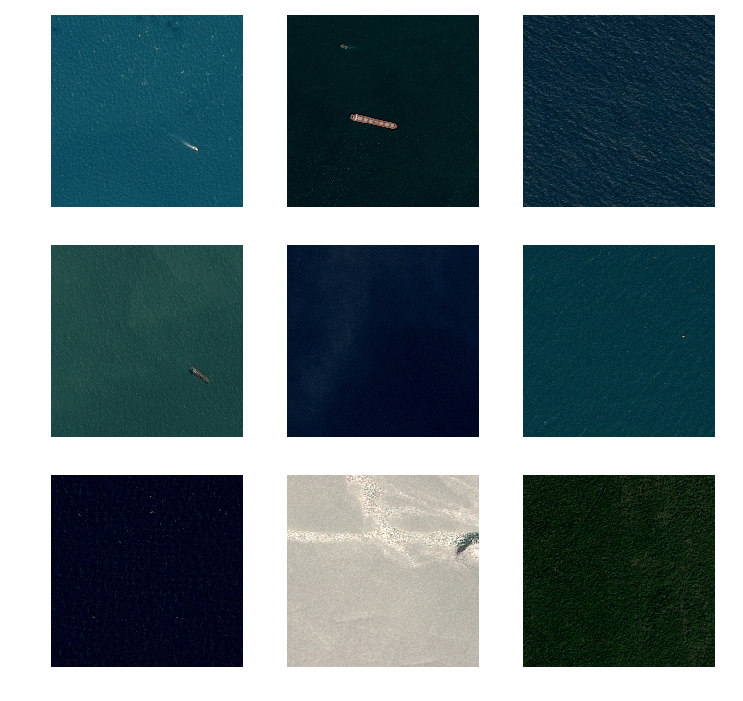

In [8]:
h, w = 3, 3

load_img = lambda filename: np.array(PIL.Image.open(f"train/{filename}").resize((200,200)))

fig, axes_list = plt.subplots(h, w, figsize=(4*h, 4*w))

for axes in axes_list:
    for ax in axes:
        ax.axis("off")
        img = np.random.choice(train)
        ax.imshow(load_img(img))

In [9]:
df = pd.read_csv('train_ship_segmentations.csv', index_col=0).dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56030 entries, 000155de5.jpg to fff77c602.jpg
Data columns (total 1 columns):
EncodedPixels    56030 non-null object
dtypes: object(1)
memory usage: 875.5+ KB


In [11]:
df.head(2)

,EncodedPixels
ImageId,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...


In [12]:
df['EncodedPixels'].iloc[0]

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [13]:
# parse and turn list of ints into a list of (`start`, `length`) `pairs`

rle = [int(i) for i in df['EncodedPixels'].iloc[0].split()]
pairs = list(zip(rle[0:-1:2], rle[1::2]))

print('start: ', rle[-2])
print('length:', rle[-1])

pairs[:3]

start:  343787
length: 8


[(264661, 17), (265429, 33), (266197, 33)]

In [14]:
start = pairs[0][0]
print(f"Original start position: {start}")

coordinate = (start % 768, start // 768)
print(f"Maps to this coordinate: {coordinate}")

back = 768 * coordinate[1] + coordinate[0]
print(f"And back: {back}")

Original start position: 264661
Maps to this coordinate: (469, 344)
And back: 264661


In [15]:
def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()]
    
    pixels = [(pixel_position % 768, pixel_position // 768) 
              for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
              for pixel_position in range(start, start + length)]
        
    return pixels

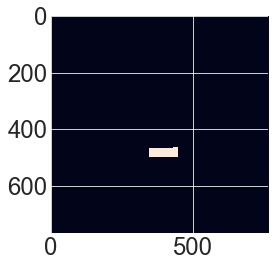

In [16]:
pixels = rle_to_pixels(df['EncodedPixels'].iloc[0])
# pixels = rle_to_pixels(np.random.choice(df['EncodedPixels']))
canvas = np.zeros((768, 768))
canvas[tuple(zip(*pixels))] = 1
plt.imshow(canvas)

In [17]:
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_code: ' '.join(rle_code)).reset_index()

In [18]:
df.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
3,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...
4,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...


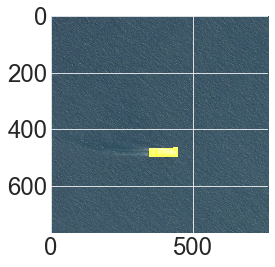

In [19]:
fig = plt.figure()

load_img = lambda filename: np.array(PIL.Image.open(f"train/{filename}"))

def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

img = load_img(df['ImageId'][0])
mask_pixels = rle_to_pixels(df['EncodedPixels'][0])
img = apply_mask(img, mask_pixels)
plt.imshow(img)

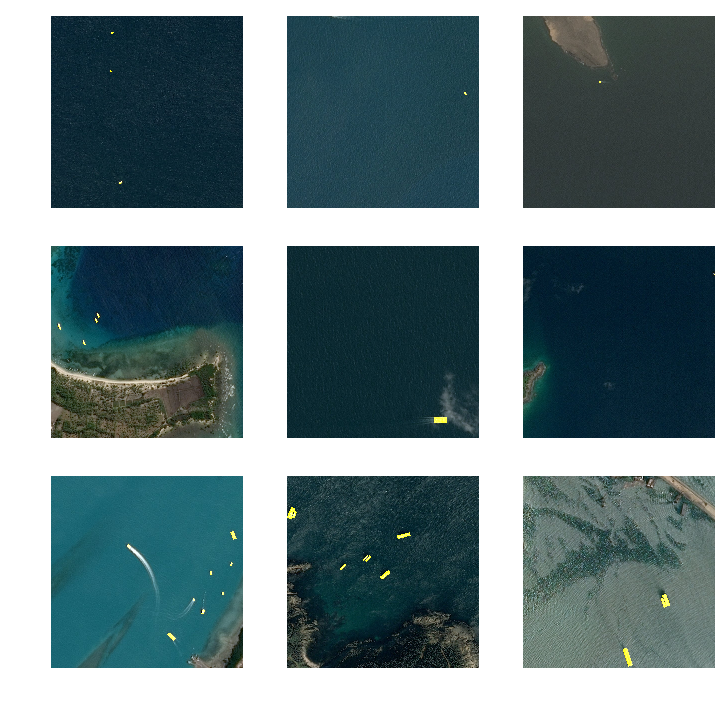

In [20]:
w, h = 3, 3

fig, axes_list = plt.subplots(w, h, figsize=(4*w, 4*h))

for axes in axes_list:
    for ax in axes:
        ax.axis("off")
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId']), \
                             rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29070 entries, 0 to 29069
Data columns (total 2 columns):
ImageId          29070 non-null object
EncodedPixels    29070 non-null object
dtypes: object(2)
memory usage: 454.3+ KB


In [22]:
df.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
3,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...
4,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...


In [23]:
df = pd.read_csv('train_ship_segmentations.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 2 columns):
ImageId          131030 non-null object
EncodedPixels    56030 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


In [24]:
df['HasShip'] = df['EncodedPixels'].notnull()
df.head()

,ImageId,EncodedPixels,HasShip
0,00003e153.jpg,NaN,False
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,True
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,True
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,True
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,True


In [25]:
df = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']})
df.columns = ['HasShip', 'TotalShips']

In [26]:
df.head()

,HasShip,TotalShips
ImageId,,
00003e153.jpg,False,0.0
000155de5.jpg,True,1.0
00021ddc3.jpg,True,9.0
0002756f7.jpg,True,2.0
0002d0f32.jpg,False,0.0


In [27]:
total = len(df)
ship = df['HasShip'].sum()
no_ship = total - ship
total_ships = df['TotalShips'].sum()

In [28]:
print(f"Images: {total} \nShips:  {total_ships}")
print(f"Images with ships:    {round(ship/total,2)} ({ship})")
print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")

Images: 104070 
Ships:  56030.0
Images with ships:    0.28 (29070)
Images with no ships: 0.72 (75000)


Text(0.5,1,'v = 1')

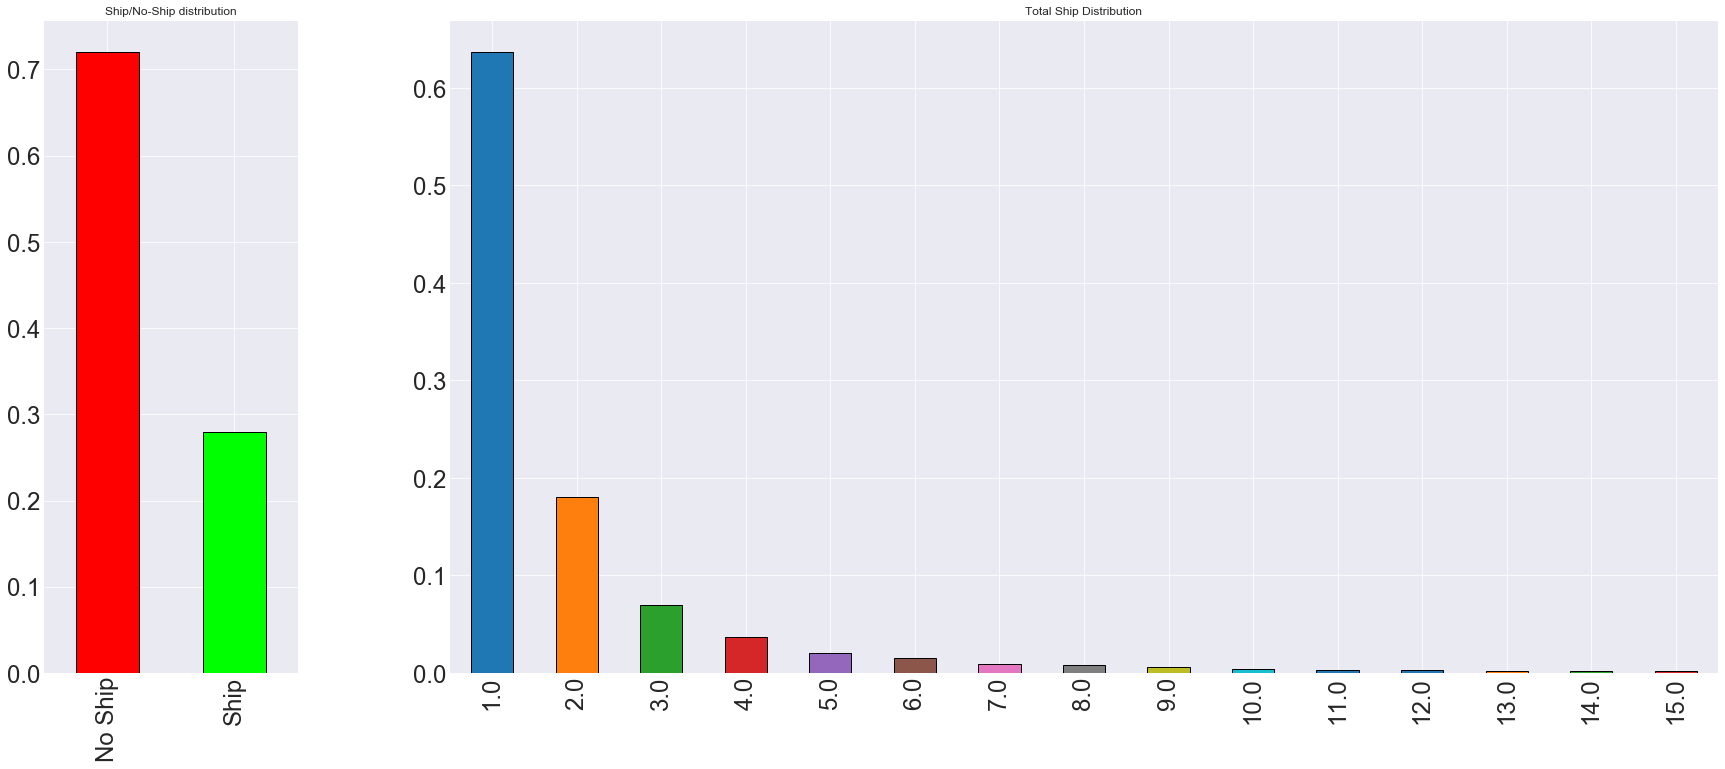

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(30,12), gridspec_kw={'width_ratios':[1, 5]})

ax.set_title('v = 1',fontweight="bold", size=100)

ship_ratio = df['HasShip'].value_counts()/total
ship_ratio = ship_ratio.rename(index={True: "Ship", False: "No Ship"})
ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], title="Ship/No-Ship distribution")

total_ship_distribution = df.loc[df['HasShip'], 'TotalShips'].value_counts() / ship
total_ship_distribution.plot(kind='bar', ax=axes[1], title="Total Ship Distribution")

ax.set_title('v = 1',fontweight="bold", size=200)

In [5]:
df = pd.read_csv('train_ship_segmentations.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 2 columns):
ImageId          131030 non-null object
EncodedPixels    56030 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


In [14]:
n_images = df['ImageId'].nunique()
total_pixels = n_images * 768 ** 2
n_images, total_pixels

(104070, 61382983680)

In [15]:
def rle_to_pixels(rle_code):
    rle = [int(i) for i in rle_code.split()]
    
    pixels = [(pixel_position % 768, pixel_position // 768)
             for start, length in list(zip(rle[:-1:2], rle[1::2])) 
             for pixel_position in range(start, start + length)]
    
    return pixels

In [19]:
# df['BoxPixels'] = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len()
ship_pixels = 87714996

In [20]:
ship_pixels = df['BoxPixels'].sum()

In [21]:
ratio = ship_pixels/total_pixels
no_ratio = (total_pixels - ship_pixels)/total_pixels

print(f'Ship Pixels:  {round(ratio, 3)*100}%  ({ship_pixels})')
print(f'Total Pixels: {round(no_ratio, 3)*100}% ({total_pixels - ship_pixels})')

Ship Pixels:  0.1%  (87714996.0)
Total Pixels: 99.9% (61295268684.0)


In [23]:
unique_ship = df.dropna()['ImageId'].nunique()
total_pixels = unique_ship * 768 ** 2
unique_ship, total_pixels

(29070, 17146183680)

In [24]:
ratio = ship_pixels/total_pixels
no_ratio = (total_pixels - ship_pixels)/total_pixels

print(f'Ship Pixels:  {round(ratio, 3)*100}%  ({ship_pixels})')
print(f'Total Pixels: {round(no_ratio, 3)*100}% ({total_pixels - ship_pixels})')

Ship Pixels:  0.5%  (87714996.0)
Total Pixels: 99.5% (17058468684.0)
